This file allows to analyze results obtained by running `experiments_ntc.py`.

It computed performance metric, analyse the evolution of likelihood given number of clusters if available, and display the obtained treatment response clusters (for the selected methodology).

In [129]:
import os 
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors

import sys
sys.path.append('../')
sys.path.append('../DeepSurvivalMachines/')
sys.path.append('../auton-survival/')

from ntc import datasets
from experiment import Experiment
from simulation.generate import generate, compute_cif


In [130]:
import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False, "axes.spines.left": False,
                 "axes.spines.bottom": False, "figure.dpi": 700, 'savefig.dpi': 300}
sns.set_theme(style = "whitegrid", rc = custom_params, font_scale = 1.75)

In [131]:
# Change this to analyze other datasets result
dataset = 'SEER'

In [132]:
path = '../Results_ntc/' # Path where the data is saved

In [133]:
x, a, t, e, covariates = datasets.load_dataset(dataset)

/home/vincent/Desktop/Thesis/NeuralTreatment/examples/../ntc/datasets.py:30: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path + 'export.csv')


In [134]:
horizons = [0.25, 0.5, 0.75] # Horizons to evaluate the models
times_eval = np.quantile(t[e > 0], horizons)

In [135]:
from pycox.evaluation import EvalSurv
from sklearn.metrics import adjusted_rand_score
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc, integrated_brier_score

def evaluate(survival_pred, a = a, t = t, e = e, times_eval = times_eval):
    """
        Evaluate the performance of the survival model on the factual loss and on the gt if available
    """
    folds = survival_pred[('Use',)].values.flatten()
    a = pd.Series(a, index = survival_pred.index).astype(bool)
    factual_survival = pd.concat([survival_pred['treated'].loc[a.loc[survival_pred.index]], survival_pred['untreated'].loc[~a.loc[survival_pred.index]]], axis = 0).loc[survival_pred.index]
    factual_survival.columns = factual_survival.columns.astype(float)
    times = factual_survival.columns.unique()
    results = {}

    
    for fold in np.arange(np.unique(folds).shape[0]):
        res = {}
        # Subselect given fold
        e_train, t_train = e[folds != fold], t[folds != fold]
        e_test,  t_test  = e[folds == fold], t[folds == fold]

        et_train = np.array([(e_train[i], t_train[i]) for i in range(len(e_train))], # For estimation censoring
                        dtype = [('e', bool), ('t', float)])
        et_test = np.array([(e_test[i], t_test[i]) for i in range(len(e_test))], # For measure performance for given outcome
                        dtype = [('e', bool), ('t', float)])
        
        selection = (t_test < t_train.max()) | (e[folds == fold] == 0)
        
        et_test = et_test[selection]
        survival_train = factual_survival[folds != fold]
        survival_fold = factual_survival[folds == fold]

        km = EvalSurv(survival_train.T, t_train, e_train, censor_surv = 'km')
        test_eval = EvalSurv(survival_fold.T, t_test, e_test, censor_surv = km)

        res['Overall'] = {
                "CIS": test_eval.concordance_td(), 
            }
        try:
            res['Overall']['BRS'] = test_eval.integrated_brier_score(times.to_numpy())
        except: pass

        if len(times_eval) > 0:
            et_train = np.array([(e_train[i], t_train[i]) for i in range(len(e_train))], # For estimation censoring
                                dtype = [('e', bool), ('t', float)])
            et_test = np.array([(e_test[i], t_test[i]) for i in range(len(e_test))], # For measure performance for given outcome
                            dtype = [('e', bool), ('t', float)])
            selection = (t_test < t_train.max()) | (e_test == 0)
            et_test = et_test[selection]
            
            indexes = [np.argmin(np.abs(times - te)) for te in times_eval]
            briers = brier_score(et_train, et_test, survival_fold[selection].iloc[:, indexes], times_eval)[1]
            for te, brier, index in zip(times_eval, briers, indexes):
                try:
                    res[te] = {
                        "CIS": concordance_index_ipcw(et_train, et_test, 1 - survival_fold[selection].iloc[:, index], te)[0], 
                        "BRS": brier,
                        "ROCS": cumulative_dynamic_auc(et_train, et_test, 1 - survival_fold[selection].iloc[:, index], te)[0][0]}
                except:
                    pass

        results[fold] = pd.DataFrame.from_dict(res)
    results = pd.concat(results)
    results.index.set_names(['Fold', 'Metric'], inplace = True)

    return results

In [43]:
# Open file and compute performance
predictions, results = {}, {}
for file_name in os.listdir(path):
    if dataset in file_name and '.csv' in file_name: 
        model = file_name       
        model = model[model.index('_') + 1: model.index('.')]

        if model == 'ntc':


            print("Opening :", file_name, ' - ', model)
            predictions[model] = pd.read_csv(path + file_name, header = [0, 1], index_col = 0)
            results[model] = evaluate(predictions[model])

# Rename
# TODO: Add your method in the list for nicer display
dict_name = {'ntc': 'NTC', 'cmhe': 'CMHE'} 

results = pd.concat(results).rename(dict_name)
results.index.set_names('Model', 0, inplace = True)

Opening : SEER_ntc.csv  -  ntc


/tmp/ipykernel_7151/585003505.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  folds = survival_pred[('Use',)].values.flatten()
/home/vincent/miniconda3/envs/Jupyter/lib/python3.9/site-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/home/vincent/miniconda3/envs/Jupyter/lib/python3.9/site-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/home/vincent/miniconda3/envs/Jupyter/lib/python3.9/site-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/home/vincent/miniconda3/envs/Jupy

In [44]:
# Compute average performance across fold and models
table = results.groupby(['Model', 'Metric']).apply(lambda x:  pd.Series(["{:.3f} ({:.3f})".format(mean, std) for mean, std in zip(x.mean(), x.std())], index = x.columns))
table = table.sort_index(level = 0, sort_remaining = False)
table

Overall    17.00000001    31.00000001    48.00000001
Model Metric                                                            
NTC   BRS     0.087 (0.002)  0.018 (0.000)  0.034 (0.001)  0.049 (0.001)
      CIS     0.871 (0.004)  0.919 (0.005)  0.900 (0.005)  0.881 (0.006)
      ROCS        nan (nan)  0.921 (0.005)  0.905 (0.005)  0.886 (0.005)

In [45]:
print(table.to_latex())

\begin{tabular}{llllll}
\toprule
    &      &        Overall &    17.00000001 &    31.00000001 &    48.00000001 \\
Model & Metric &                &                &                &                \\
\midrule
NTC & BRS &  0.087 (0.002) &  0.018 (0.000) &  0.034 (0.001) &  0.049 (0.001) \\
    & CIS &  0.871 (0.004) &  0.919 (0.005) &  0.900 (0.005) &  0.881 (0.006) \\
    & ROCS &      nan (nan) &  0.921 (0.005) &  0.905 (0.005) &  0.886 (0.005) \\
\bottomrule
\end{tabular}



/tmp/ipykernel_7151/3293683267.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex())


---------

# Likelihood evolution

In [52]:
# Anlayze the outcome of the clustering method 
method_display = 'cmhe' 

In [53]:
# Load models in family
likelihood = {}
for file_name in os.listdir(path):
    if '{}_{}+k='.format(dataset, method_display) in file_name and '.pickle' in file_name and '_' not in file_name[file_name.index('k='):]:
        model = int(file_name[file_name.rindex('k=')+2: file_name.index('.')])
        print("Likelihood Computation :", file_name, ' - ', model)

        model_pickle = Experiment.load(path + file_name)
        likelihood[model] = model_pickle.likelihood(x, t, e, a)

likelihood = pd.DataFrame.from_dict(likelihood, 'index')

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

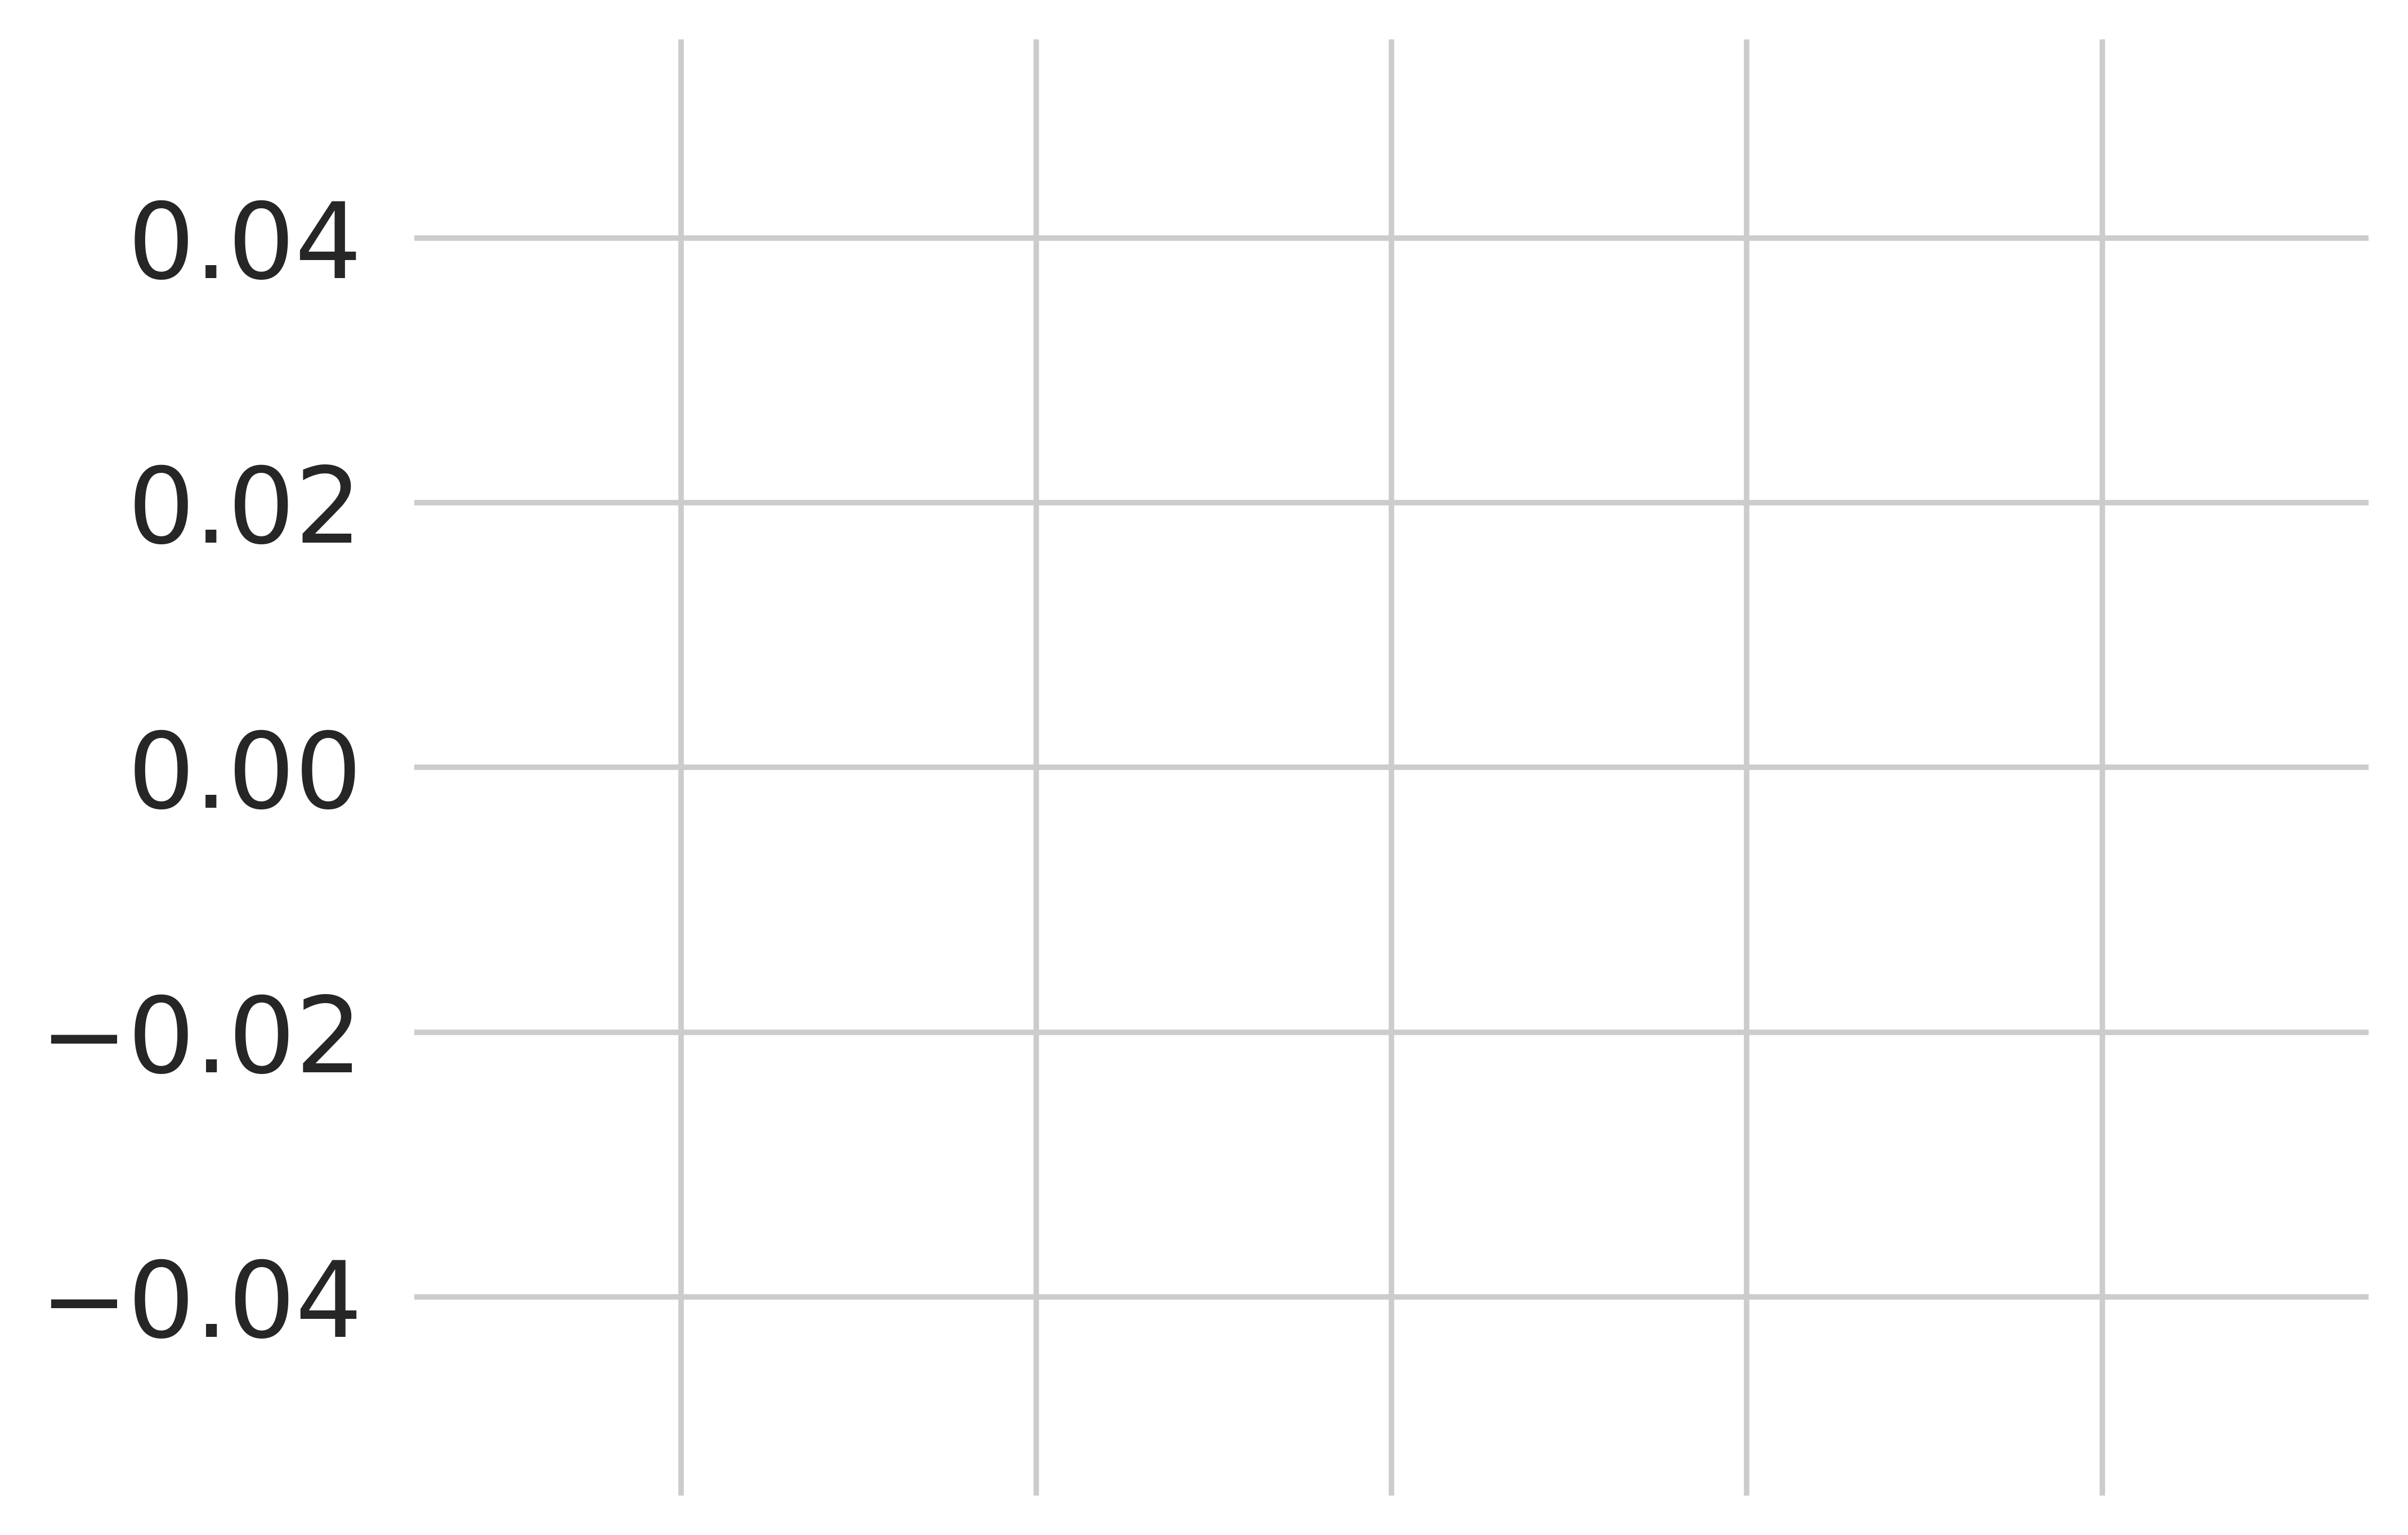

In [54]:
mean = likelihood.sort_index().mean(1)
std = 1.96 * likelihood.sort_index().std(1) / np.sqrt(5)

mean.plot()
plt.fill_between(std.index, mean + std, mean - std, alpha = 0.3)
plt.grid(alpha = .3)

plt.xlabel(r'Number of clusters $K$')
plt.ylabel(r'Negative Log Likelihood')

---------

# Analysis cluster

In [162]:
# Anlayze the outcome of the clustering method 
method_display = 'cmhe' 

In [163]:
assignment = {}
horizon = 5

In [164]:
ax = None
for i in np.arange(5):
    horizons_pred = np.linspace(0, 0.75, 10)
    pred = predictions[method_display]
    pred = pred[(pred.Use == i).values]

    assignment[i] = pred.Assignment.idxmax(1)
    for treat in ['treated', 'untreated']:
        pred_treat = pred[treat]
        pred_treat.columns = pred_treat.columns.map(float)
        ax = pred_treat.groupby(assignment[i]).mean(0).T.plot(ax = ax, ls = '--' if treat == 'untreated' else '-')
plt.xlabel('Time')
plt.ylabel('Survival Predictions')
plt.grid(alpha = 0.3)
plt.show()

KeyError: 'cmhe'

In [165]:
# Load the experiment associated - Only works when predcit_cluster is available
for file_name in os.listdir(path):
    if dataset in file_name and method_display + '.pickle' in file_name:
        print("Cluster Computation :", file_name)

        model_pickle = Experiment.load(path + file_name)
        clusters = model_pickle.clusters(model_pickle.times)

Cluster Computation : SEER_cmhe.pickle


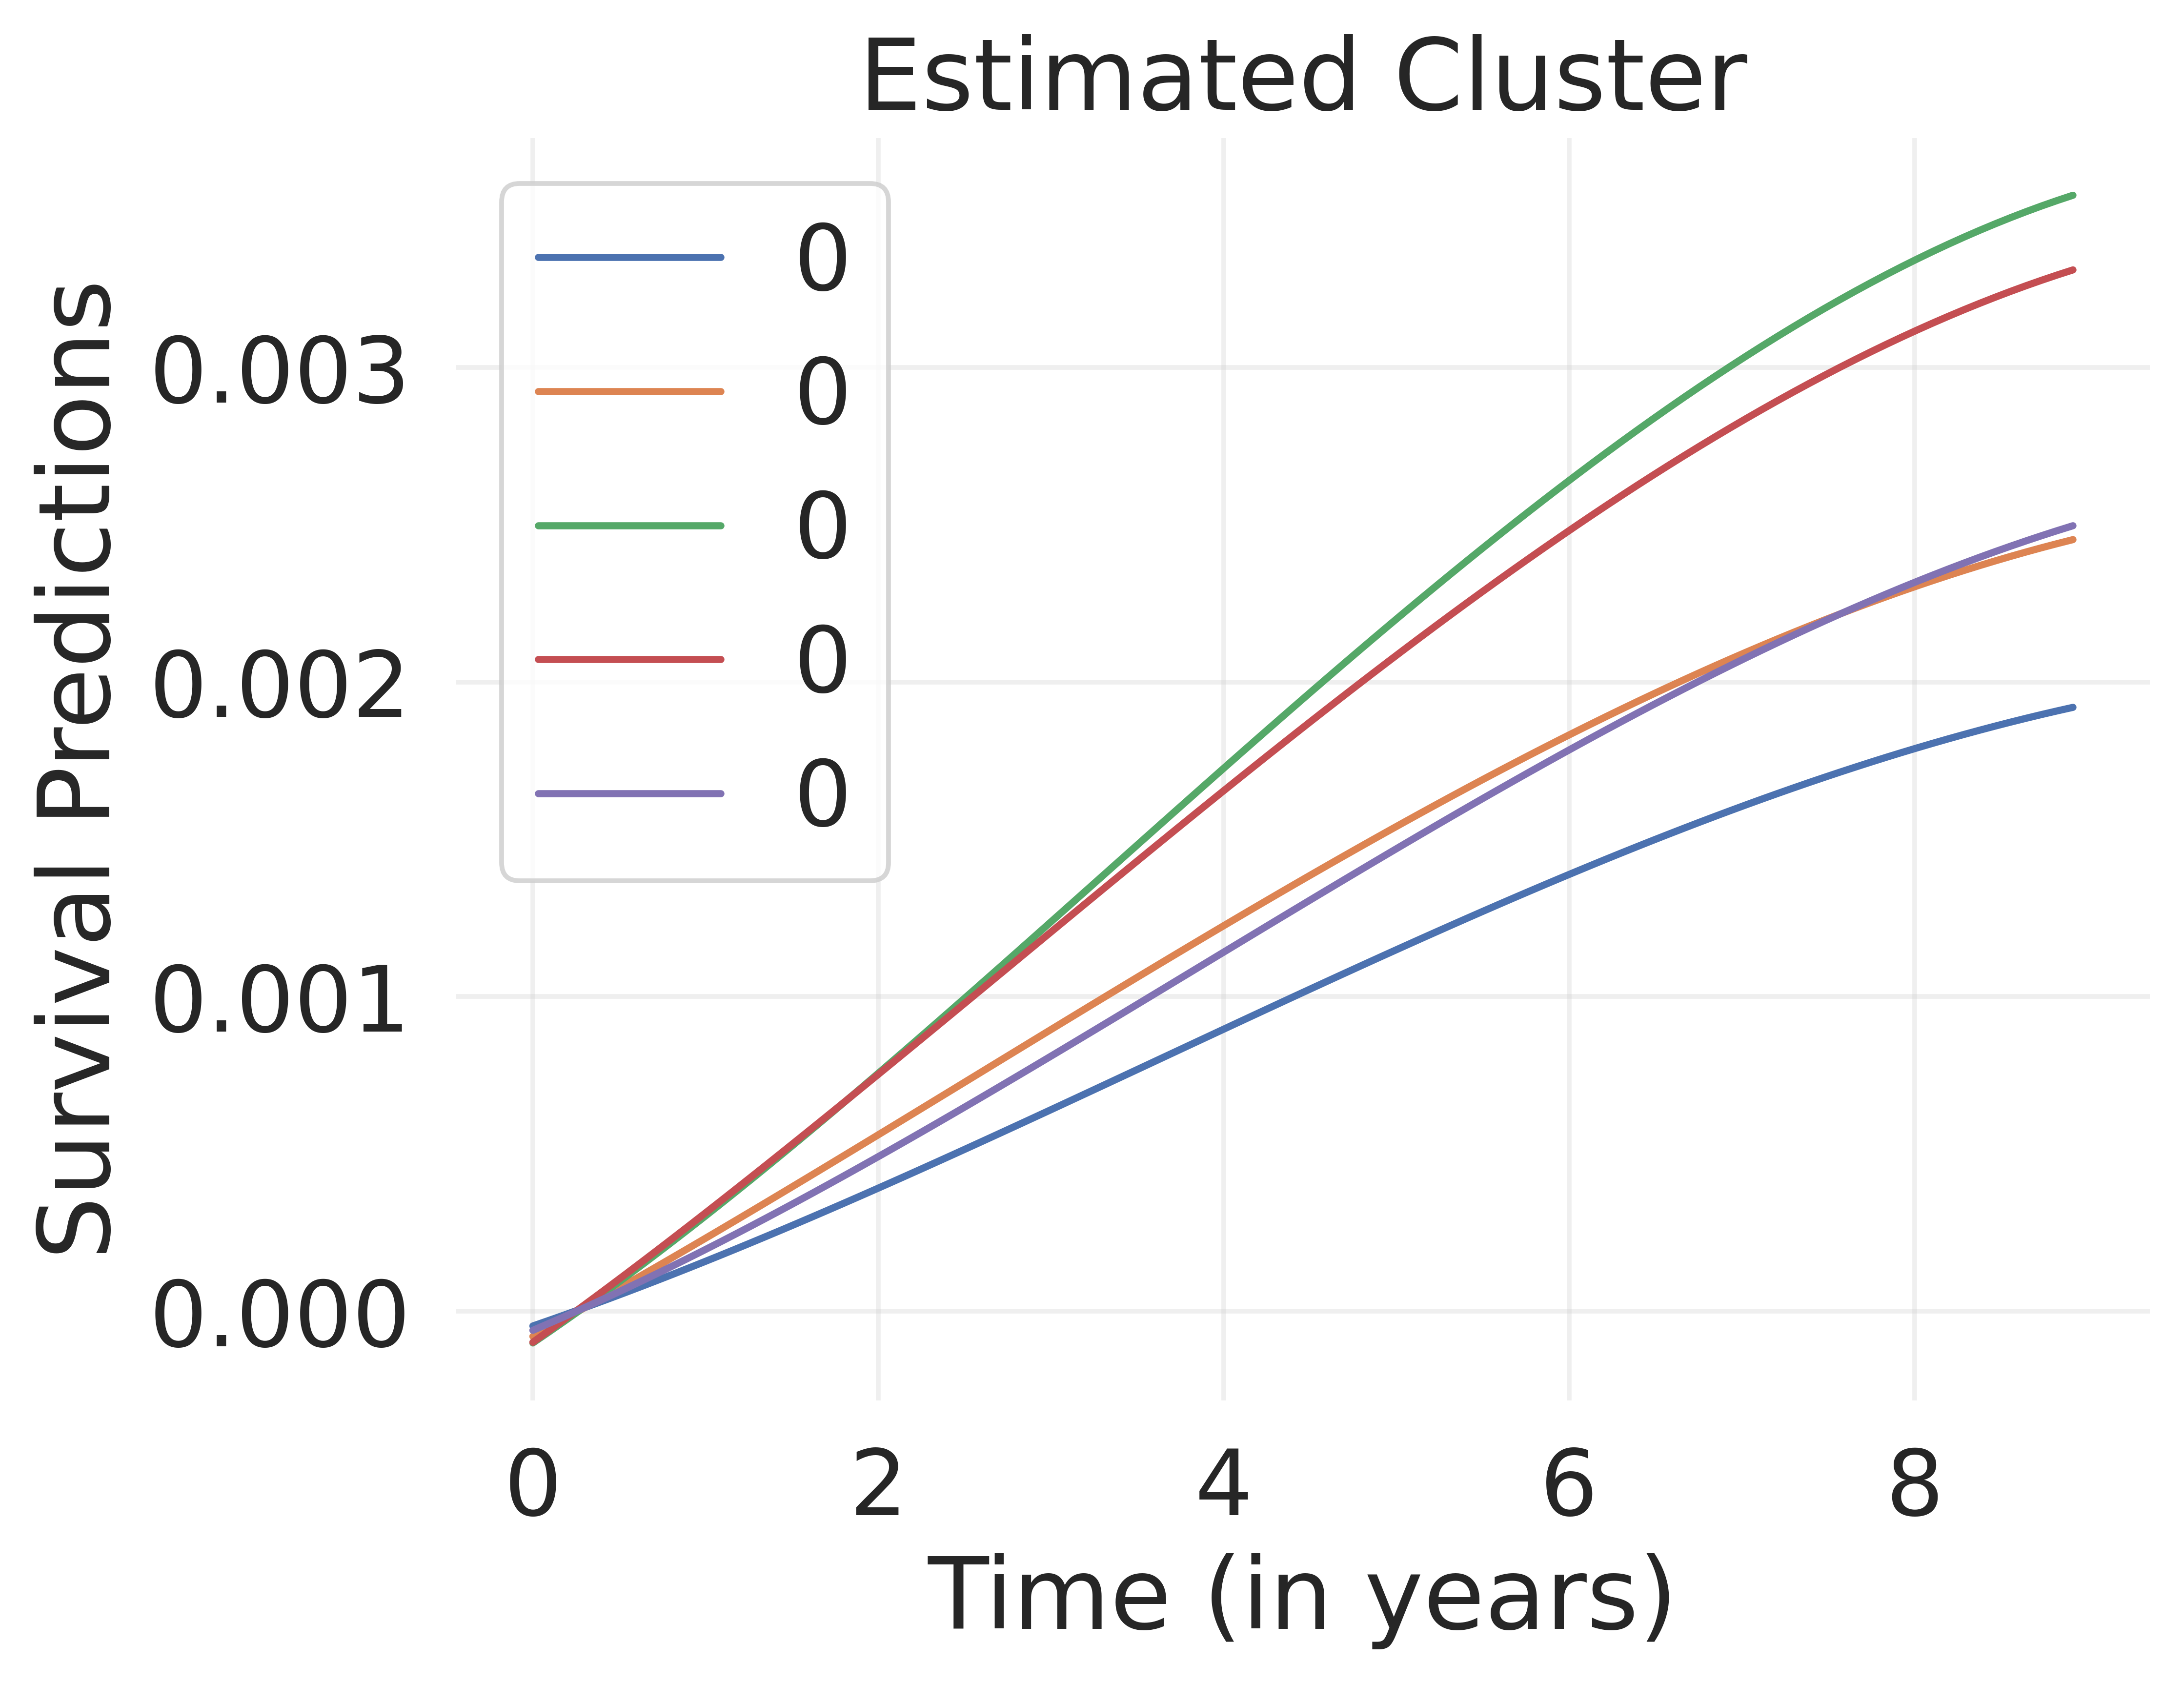

In [166]:
ax = None
for i in clusters:
    ax = pd.DataFrame(clusters[i], index = model_pickle.times / 12).plot(ax = ax)
plt.xlabel('Time (in years)')
plt.ylabel('Survival Predictions')
plt.title('Estimated Cluster')
plt.grid(alpha = 0.3)
plt.show()

(0.0, 0.1)

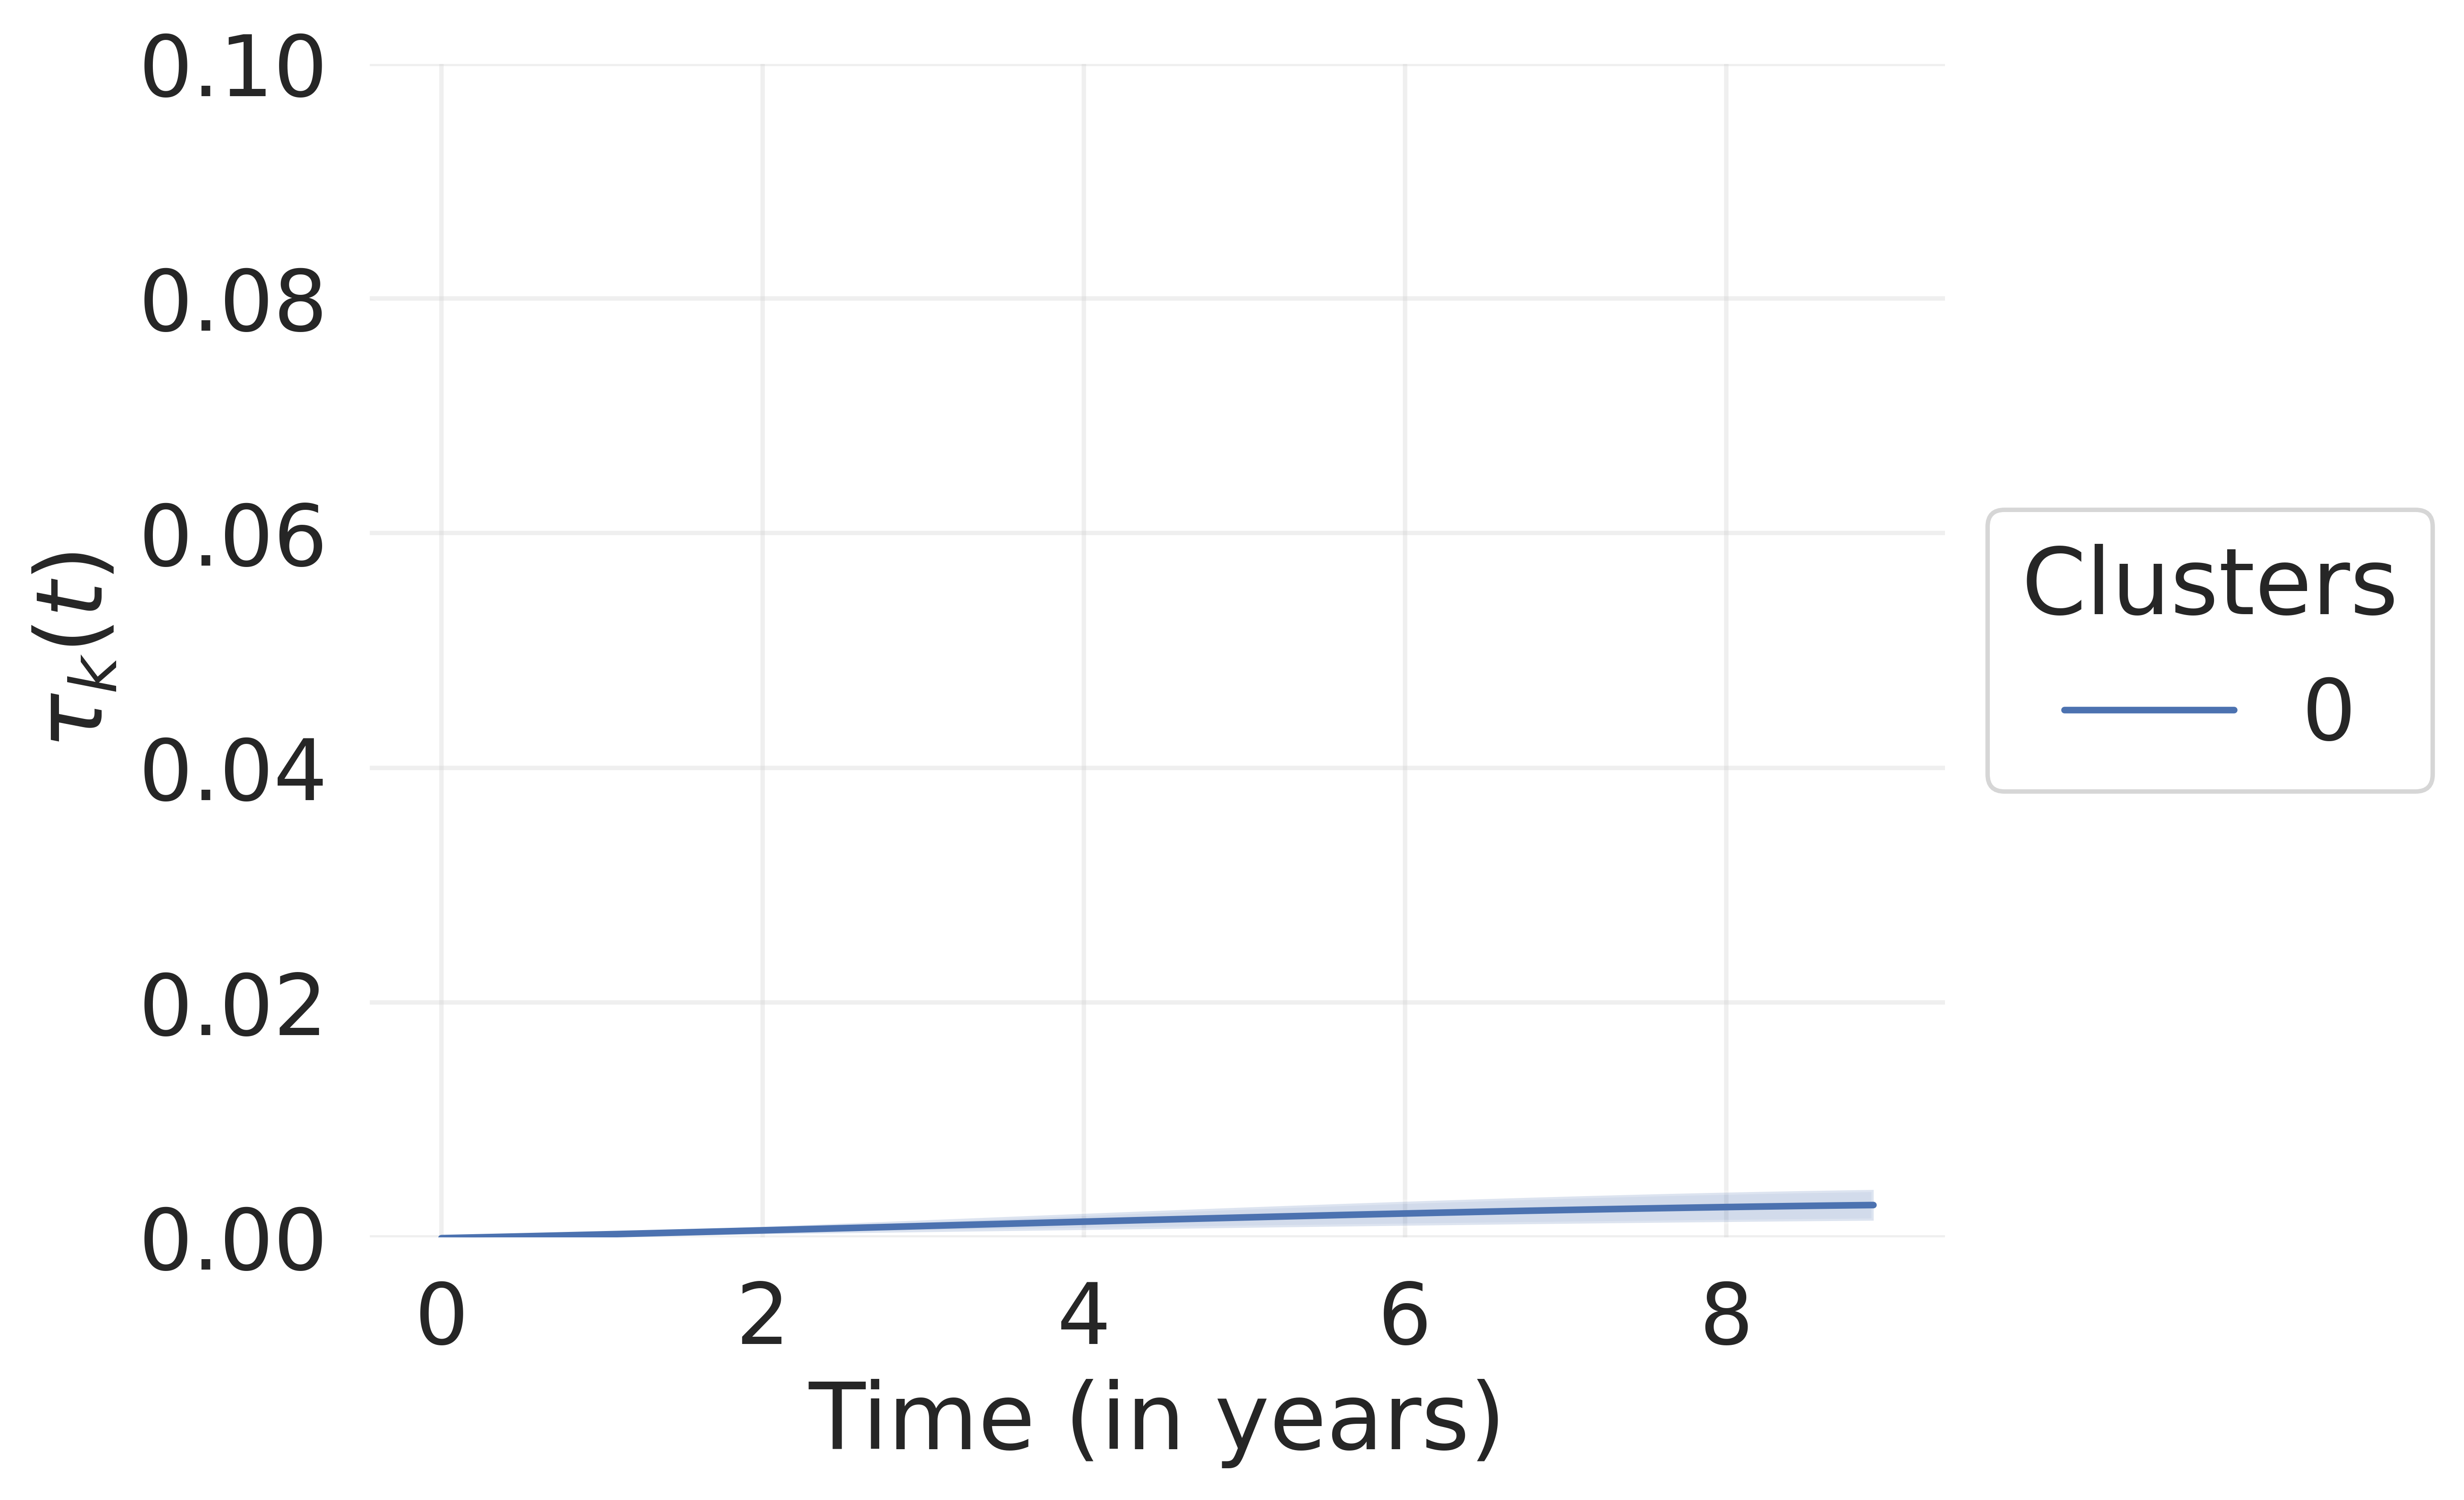

In [169]:
te_cluster, ordering, rmst = {}, {}, {}
# Sort treatment effect
for fold in clusters:
    #selection = (predictions[method_display].Use == fold).values.flatten()
    #unique = predictions[method_display][selection].Assignment.idxmax(1).unique().astype(float)
    te = pd.DataFrame(clusters[fold], index = model_pickle.times / 12).T.rename_axis('Cluster')#.loc[unique]
    ordering[fold] = {i: j for j, i in enumerate(te.T.mean().sort_values().index)}
    te_cluster[fold] = te.rename(index = ordering[fold])
    step = te.columns[1] - te.columns[0]
    rmst[fold] = te_cluster[fold].loc[:, te.columns < horizon].mean(1) / step

te_cluster = pd.concat(te_cluster, names = ['Fold'])
mean = te_cluster.groupby('Cluster').mean().T
std = 1.96 * te_cluster.groupby('Cluster').std().T / np.sqrt(len(mean.columns))
ax = mean.plot(legend = False)
for k in mean.columns:
    ax.fill_between(mean.index, mean[k] + std[k], mean[k] - std[k], alpha = 0.25)

ax.grid(alpha = 0.3)
ax.legend(title = 'Clusters', loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel(r'$\tau_k(t)$')
plt.xlabel('Time (in years)')
plt.ylim(0,0.1)

In [91]:
print('RMST at {} years'.format(horizon))
pd.concat(rmst, axis = 1).T.mean(), pd.concat(rmst, axis = 1).T.std()

RMST at 5 years


(Cluster
 0    0.003798
 1    0.620013
 dtype: float64,
 Cluster
 0    0.001866
 1    0.158405
 dtype: float64)

---------

# Cluster Exploration

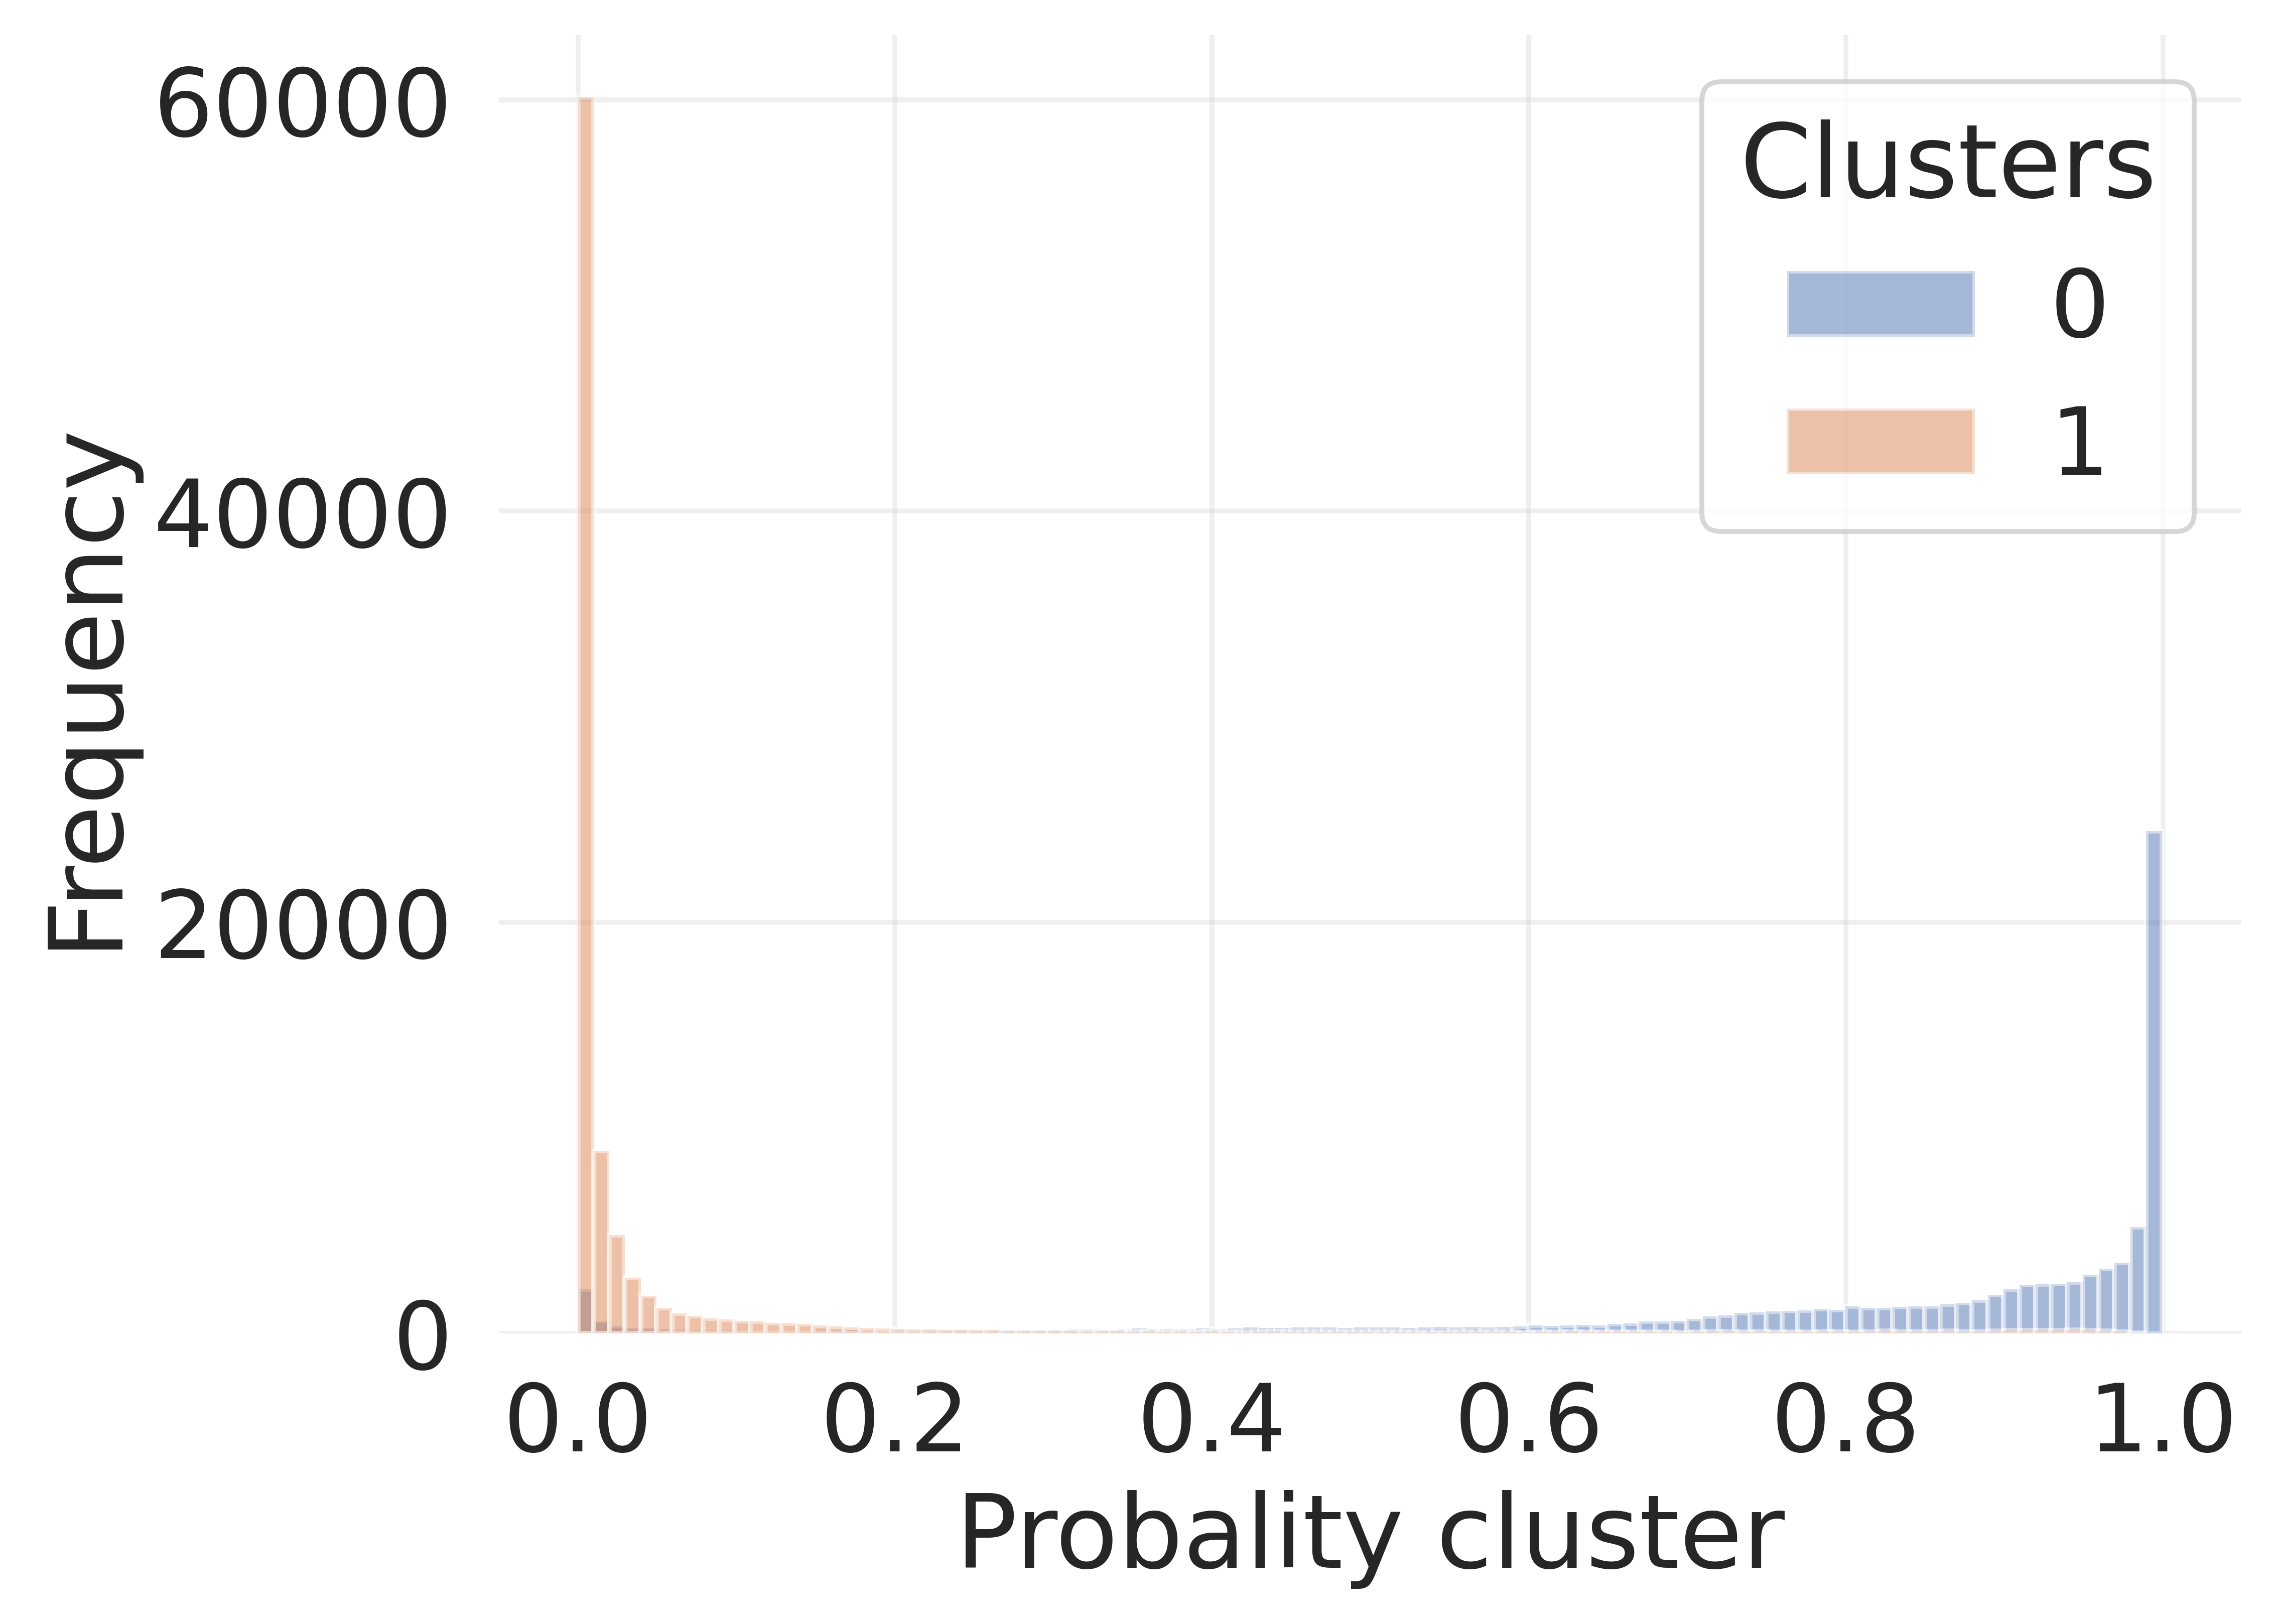

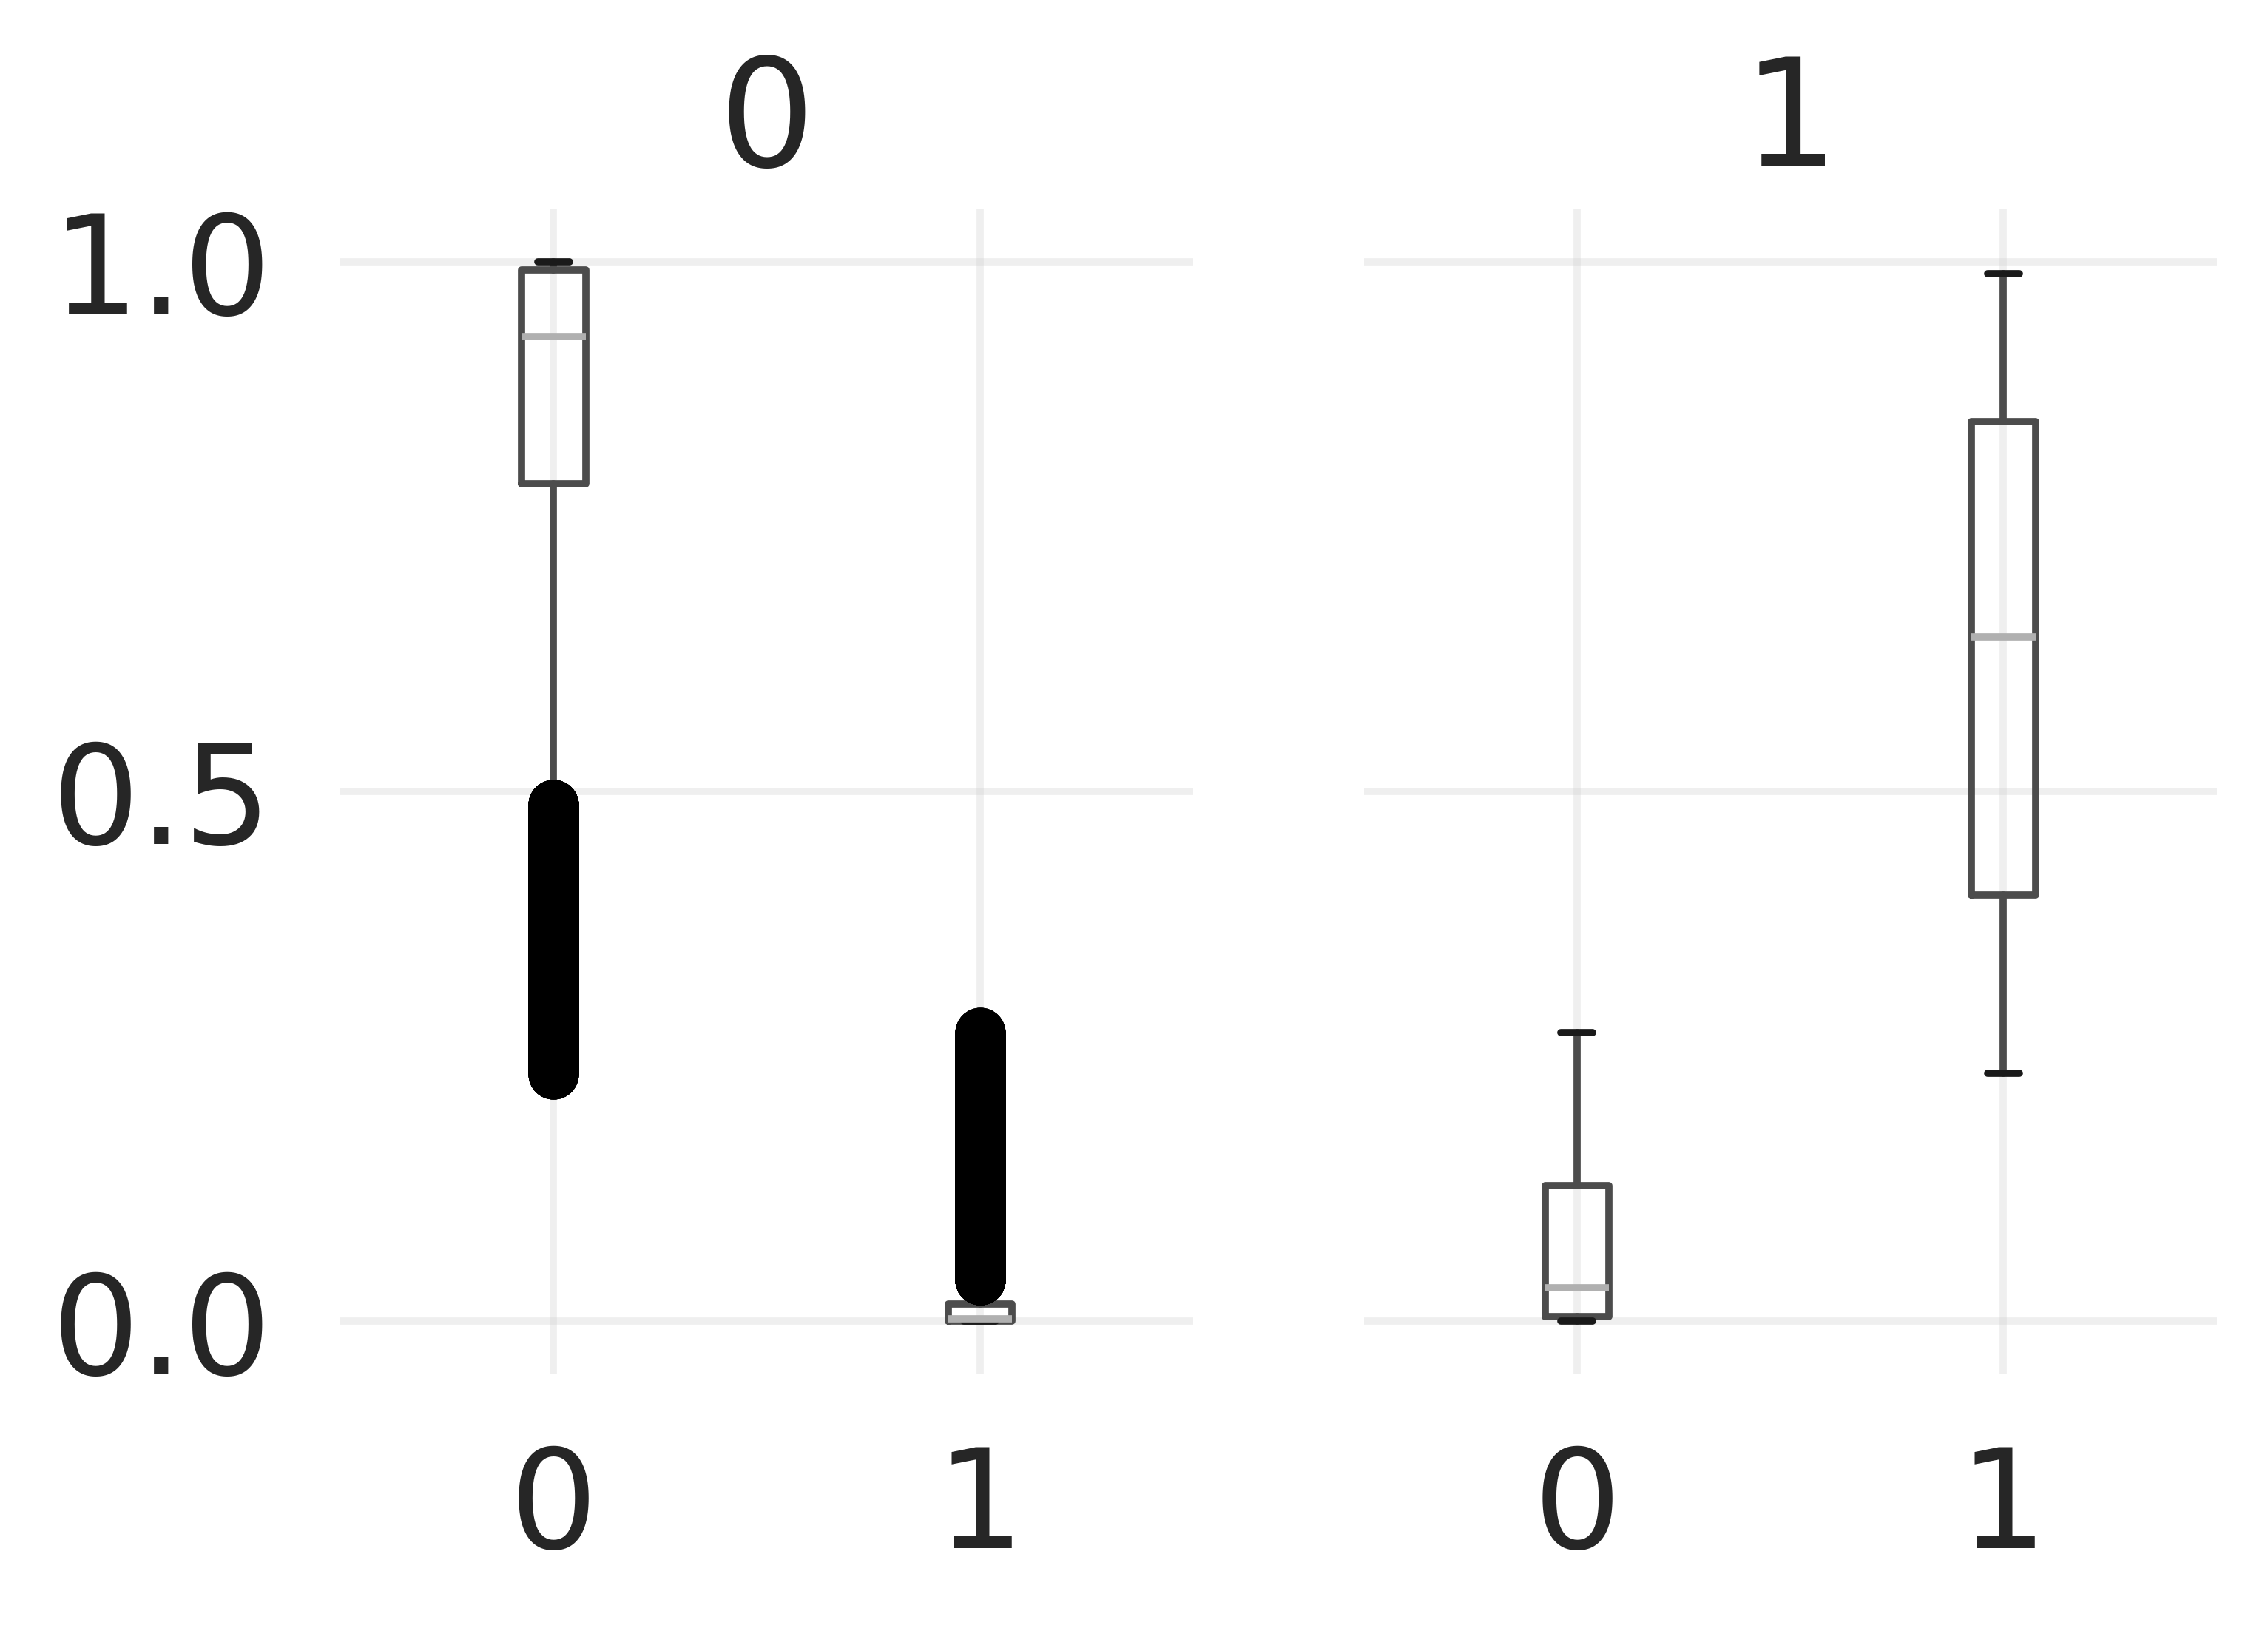

In [102]:
# What is the distribution of probability to be part of a given cluster ?
clusters_assignment = {}
for fold in clusters:
    selection = (predictions[method_display].Use == fold).values.flatten()
    unique = predictions[method_display][selection].Assignment.idxmax(1).unique().astype(float)
    clusters_assignment[fold] = predictions[method_display][selection].Assignment
    clusters_assignment[fold].columns = clusters_assignment[fold].columns.astype(float)
    clusters_assignment[fold] = clusters_assignment[fold][unique].rename(columns = ordering[fold])

clusters_assignment = pd.concat(clusters_assignment, axis = 0)
for cluster in clusters_assignment.columns:
    clusters_assignment[cluster].plot.hist(alpha = 0.5, bins = 100)
plt.xlabel('Probality cluster')
plt.grid(alpha = 0.3)
plt.legend(title = 'Clusters')
plt.show()

# Distribution maximally assigned
axes = clusters_assignment.groupby(clusters_assignment.apply(lambda x: np.argmax(x), axis = 1)).boxplot(layout = (1, 3), figsize = (7, 3), grid = 0.5)
for ax in axes:
    ax.grid(alpha = 0.3)

---------

# Cluster Importance

In [139]:
# Only available for NTC
for file_name in os.listdir(path):
    if dataset in file_name and method_display + '.pickle' in file_name:
        print("Importance Computation :", file_name)

        model_pickle = Experiment.load(path + file_name)
        importance = model_pickle.importance(x, t, e, a, n = 100)

Importance Computation : SEER_ntc.pickle


100%|██████████| 100/100 [11:04<00:00,  6.65s/it]


In [140]:
for fold in importance:
    importance[fold] = pd.Series(importance[fold][0])
importance = - pd.concat(importance, 1, names = ['Fold'])

/tmp/ipykernel_7151/2750165431.py:3: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  importance = - pd.concat(importance, 1, names = ['Fold'])


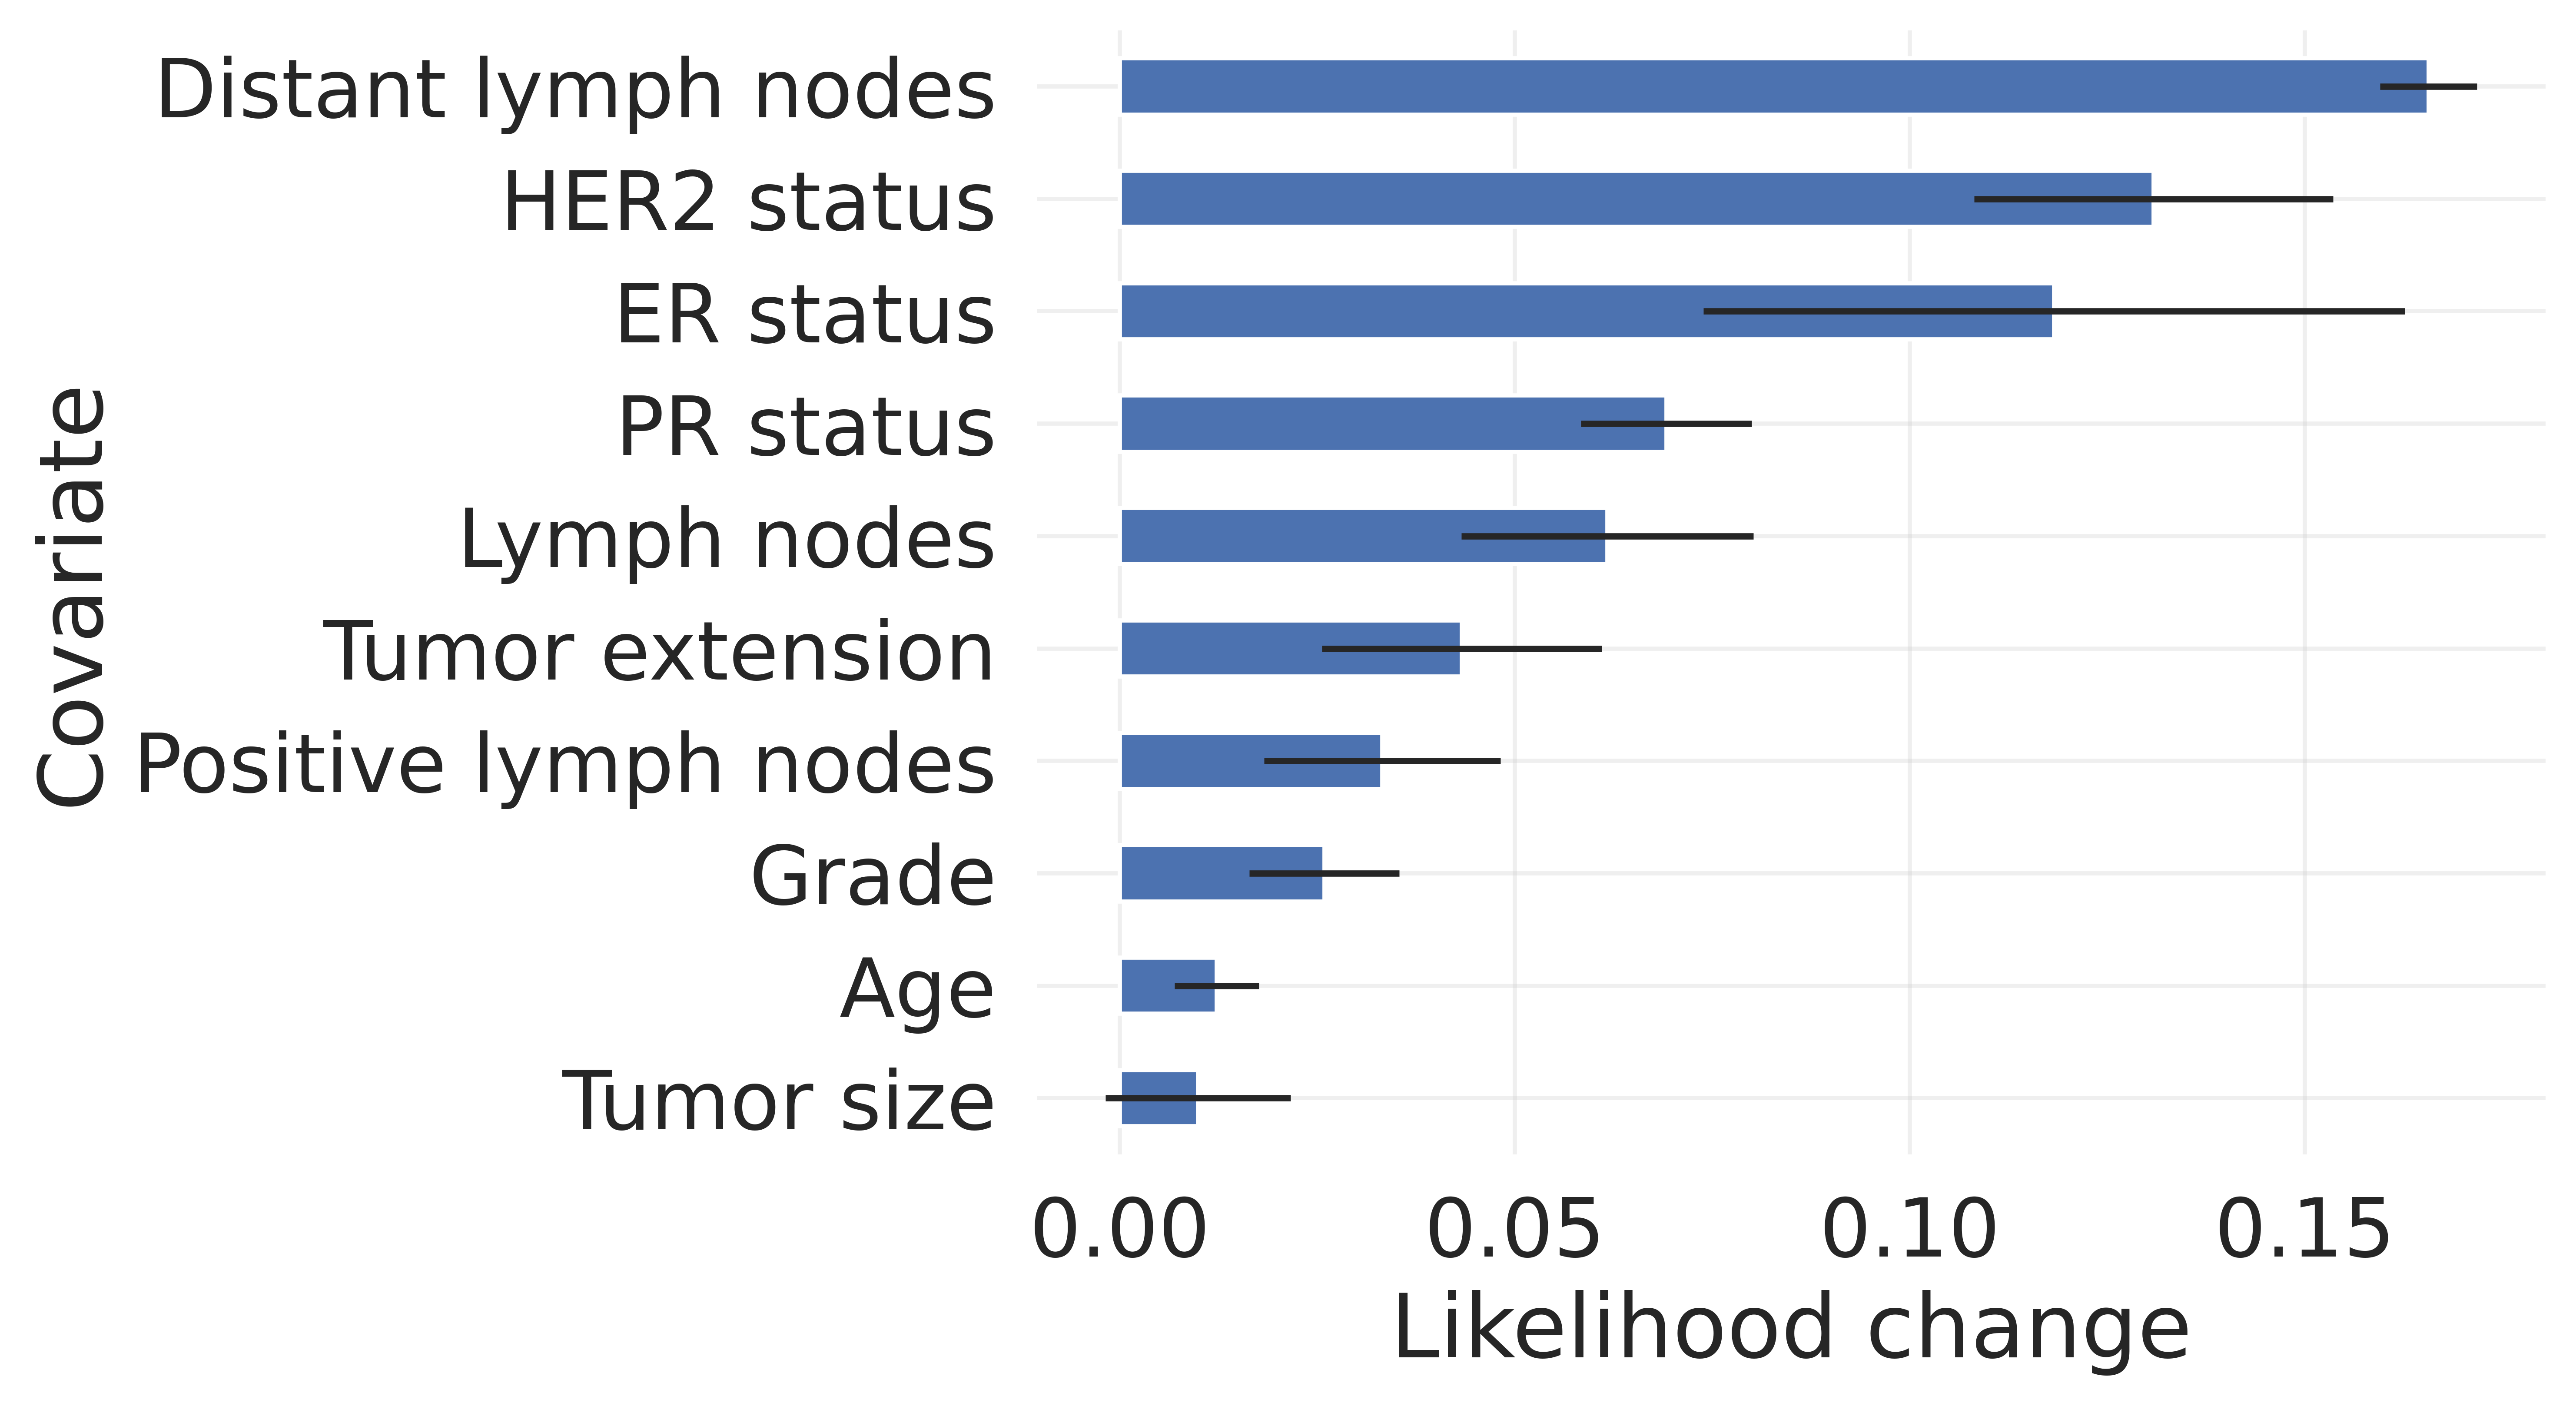

In [143]:
# Display importance of features obtained by test
importance.index = covariates.to_series().replace({'CS mets at dx (2004-2015)': 'Distant lymph nodes', 
                                       'Derived HER2 Recode (2010+)': 'HER2 status',
                                       'ER Status Recode Breast Cancer (1990+)': 'ER status',
                                       'CS lymph nodes (2004-2015)': 'Lymph nodes',
                                       'PR Status Recode Breast Cancer (1990+)': 'PR status',
                                       'CS extension (2004-2015)': 'Tumor extension',
                                       'Regional nodes positive (1988+)': 'Positive lymph nodes',
                                       'Age recode with <1 year olds': 'Age',
                                       'Grade (thru 2017)': 'Grade',
                                       'CS tumor size (2004-2015)': 'Tumor size'}).values
importance.mean(1).sort_values()[-10:].plot.barh(xerr = importance.std(1))
plt.ylabel('Covariate')
plt.xlabel('Likelihood change')
plt.grid(alpha = 0.3)

-----

# Characteristics

In [146]:
# Reopen non normalised data
x, a, t, e, covariates = datasets.load_dataset(dataset, standardisation = False)

/home/vincent/Desktop/Thesis/NeuralTreatment/examples/../ntc/datasets.py:30: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path + 'export.csv')


In [147]:
# Binarized cluster (note that it is the aligned number)
binarized = clusters_assignment.idxmax(1).astype(int)
binarized.index = binarized.index.get_level_values(1)
binarized = binarized.sort_index()

In [148]:
pd.DataFrame(x, columns = covariates).groupby(binarized).apply(lambda x:  pd.Series(["{:.3f} ({:.3f})".format(mean, std) for mean, std in zip(x.mean(), x.std())], index = x.columns)).T

,0,1
"Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)",3.696 (1.826),3.464 (1.862)
Laterality,2.705 (1.807),2.939 (2.002)
Diagnostic Confirmation,2.998 (0.063),2.996 (0.090)
Histology recode - broad groupings,7.979 (3.607),8.816 (1.226)
ER Status Recode Breast Cancer (1990+),2.167 (0.719),1.462 (0.544)
PR Status Recode Breast Cancer (1990+),2.085 (0.788),1.318 (0.521)
Histologic Type ICD-O-3,92.922 (36.184),107.268 (17.291)
"ICD-O-3 Hist/behav, malignant",92.922 (36.184),107.268 (17.291)
Sequence number,5.598 (2.651),5.715 (2.561)
Derived HER2 Recode (2010+),1.858 (0.931),1.168 (0.522)


In [149]:
pd.DataFrame(x, columns = covariates)['Derived HER2 Recode (2010+)'].groupby(binarized).value_counts(normalize = True)

   Derived HER2 Recode (2010+)
0  1.0                            0.453158
   3.0                            0.352310
   2.0                            0.174187
   0.0                            0.020345
1  1.0                            0.699032
   2.0                            0.234492
   0.0                            0.066476
Name: Derived HER2 Recode (2010+), dtype: float64

In [151]:
df = pd.read_csv('../data/export.csv')
df = df.groupby('Patient ID').first().drop(columns= ['Site recode ICD-O-3/WHO 2008'])

# Encode using dictionary to remove missing data
df["RX Summ--Surg Prim Site (1998+)"].replace('126', np.nan, inplace = True)

# Remove not grades
grades = ['Well differentiated; Grade I', 'Moderately differentiated; Grade II',
    'Poorly differentiated; Grade III', 'Undifferentiated; anaplastic; Grade IV']
df = df[df["Grade (thru 2017)"].isin(grades)]

categorical_col = ["Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)", "Laterality", 
    "Diagnostic Confirmation", "Histology recode - broad groupings", 
    "Radiation recode", "ER Status Recode Breast Cancer (1990+)", "PR Status Recode Breast Cancer (1990+)",
    "Histologic Type ICD-O-3", "ICD-O-3 Hist/behav, malignant", "Sequence number", "Derived HER2 Recode (2010+)",
    "CS extension (2004-2015)", "CS lymph nodes (2004-2015)", "CS mets at dx (2004-2015)", "Origin recode NHIA (Hispanic, Non-Hisp)"]

# Remove patients without surgery
df = df[df["RX Summ--Surg Prim Site (1998+)"] != '00']

# Remove patients without chemo
df = df[df["Chemotherapy recode (yes, no/unk)"] == 'Yes']

/tmp/ipykernel_7151/1732355379.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/export.csv')


In [158]:
df.reset_index(inplace = True)

In [161]:
df['Derived HER2 Recode (2010+)'].groupby(binarized).value_counts(normalize = True)

   Derived HER2 Recode (2010+)
0  Negative                       0.453158
   Recode not available           0.352310
   Positive                       0.174187
   Borderline/Unknown             0.020345
1  Negative                       0.699032
   Positive                       0.234492
   Borderline/Unknown             0.066476
Name: Derived HER2 Recode (2010+), dtype: float64

In [118]:
pd.Series(a).groupby(binarized).mean()

0    0.555644
1    0.475329
dtype: float64

In [119]:
pd.Series(a).groupby(binarized).size() / len(a)

0    0.933115
1    0.066885
dtype: float64